# Температурный пайплайн (модульный)
*Последнее обновление: 2025-09-07*


In [215]:
# === 1) Параметры минимального пайплайна ===
import os, io, csv, glob
from typing import List, Tuple, Optional, Dict

import numpy as np
import pandas as pd
from IPython.display import display

# Параметры
DATE_FORMAT = ''
REF_IDX = 8
N_FOLLOW = 3
WINDOW_N = 50
STD_THR = 2e-3
DIFF_THR = 2e-3
MIN_LEN = 20
DEG_TOL = 1.0
MAX_REF_DRIFT = 0.3
GROUP_BY_FILE = True

# Имена датчиков для отчёта
REF_NAME = globals().get('REF_NAME', 'Эталон 2-1')
SENSOR_NAMES = globals().get('SENSOR_NAMES', {
    'T9': 'Датчик 1-7',
    'T10': 'Датчик 1-8',
    'T11': 'Датчик 1-9',
})
# Альтернатива: список имён в порядке датчиков T{REF_IDX+1}..T{REF_IDX+N_FOLLOW}


In [216]:
# === 2) Загрузка/парсинг ===
def sniff_sep(sample: bytes) -> str:
    try:
        dialect = csv.Sniffer().sniff(sample.decode('utf-8', errors='ignore'),
                                      delimiters=[',',';','\t','|'])
        return dialect.delimiter
    except Exception:
        line = sample.decode('utf-8', errors='ignore').splitlines()[0] if sample else ''
        for cand in [',',';','\t','|']:
            if line.count(cand) >= 1:
                return cand
        return ','

def read_one_table(name: str, stream: io.BytesIO, date_format: Optional[str]=None) -> pd.DataFrame:
    head = stream.read(8192); stream.seek(0)
    sep = sniff_sep(head)
    df = pd.read_csv(stream, sep=sep, engine='python')
    if df.shape[1] < 17:
        raise ValueError(f"{name}: найдено {df.shape[1]} столбцов, требуется >= 17 (1 дата + 16 температур).")
    df = df.iloc[:, :17].copy()
    df.columns = ['date'] + [f'T{i}' for i in range(16)]
    if date_format and date_format.strip():
        df['date'] = pd.to_datetime(df['date'], format=date_format, errors='coerce')
    else:
        df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, errors='coerce', dayfirst=True)
    if df['date'].isna().any():
        bad = int(df['date'].isna().sum()); print(f"[Предупреждение] {name}: {bad} строк с нераспознанной датой отброшены.")
        df = df.dropna(subset=['date'])
    for c in [f'T{i}' for i in range(16)]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df['source_file'] = name
    return df


In [217]:
# === 3) Функции стабильности (минимум) ===
import numpy as np
import pandas as pd
from typing import List, Tuple, Sequence, Dict, Optional

def rolling_std_mask(series, window, threshold):
    rs = series.rolling(window=window, min_periods=window).std()
    return (rs <= threshold)

def rolling_mean_abs_diff_mask(series, window, diff_threshold):
    d = series.diff().abs()
    m = d.rolling(window=window, min_periods=window).mean()
    return (m <= diff_threshold)

def segments_from_mask(mask, window):
    import numpy as _np
    arr = mask.to_numpy() if hasattr(mask, 'to_numpy') else _np.asarray(mask)
    segs = []; cur=None
    for i, ok in enumerate(arr):
        if ok:
            s = max(0, i - window + 1); e = i
            if cur is None: cur=(s,e)
            else:
                cs, ce = cur
                if s <= ce + 1: cur=(cs, max(ce, e))
                else: segs.append(cur); cur=(s,e)
        else:
            if cur is not None: segs.append(cur); cur=None
    if cur is not None: segs.append(cur)
    return segs

def summarize_interval(df, cols, s, e):
    row={'start_idx':int(s),'end_idx':int(e),'length':int(e-s+1)}
    row['start_date']=pd.to_datetime(df.loc[s,'date']) if s < len(df) else pd.NaT
    row['end_date']=pd.to_datetime(df.loc[e,'date']) if e < len(df) else pd.NaT
    for c in cols:
        vals = df[c].to_numpy()[s:e+1]
        good = ~np.isnan(vals)
        row[f'mean_{c}'] = float(np.nanmean(vals)) if good.any() else np.nan
        row[f'std_{c}'] = float(np.nanstd(vals, ddof=1)) if good.sum()>1 else np.nan
        row[f'min_{c}'] = float(np.nanmin(vals)) if good.any() else np.nan
        row[f'max_{c}'] = float(np.nanmax(vals)) if good.any() else np.nan
        row[f'drift_{c}'] = row[f'max_{c}'] - row[f'min_{c}'] if good.any() else np.nan
    return row

def median_level(series, s, e):
    vals = series.to_numpy()[int(s):int(e)+1]
    return float(np.nanmedian(vals))

def split_segment_by_ref_buckets(ref_series, s, e, deg_tol):
    vals = ref_series.to_numpy()[s:e+1]
    if len(vals)==0 or np.all(np.isnan(vals)): return [(s,e)]
    buckets = np.floor(vals/float(deg_tol)).astype('float64')
    mask_good = ~np.isnan(buckets)
    if mask_good.any():
        last=None
        for i in range(len(buckets)):
            if np.isnan(buckets[i]):
                buckets[i] = last if last is not None else buckets[mask_good][0]
            last=buckets[i]
    segments=[]; start=s; base=buckets[0]
    for i in range(1,len(buckets)):
        if buckets[i]!=base:
            segments.append((start, s+i-1)); start=s+i; base=buckets[i]
    segments.append((start,e))
    return segments

def detect_stability_improved(data, ref_idx, follow_idxs, window=20, std_thr=0.05, diff_thr=0.002, min_len=20, group_by_file=True, split_by_ref_buckets=True, deg_tol=1.0, max_ref_drift=0.3):
    ref_col=f'T{ref_idx}'; follow_cols=[f'T{i}' for i in follow_idxs]
    for c in [ref_col]+follow_cols:
        if c not in data.columns: raise ValueError(f'Missing column: {c}')
    if group_by_file and 'source_file' in data.columns:
        first_idx_by_source = (data.index.to_series().groupby(data['source_file']).min().astype(int).to_dict())
        groups=list(data.groupby('source_file', sort=False))
    else:
        first_idx_by_source=None; groups=[('ALL', data)]
    joint_rows=[]; by_sensor_rows=[]
    for src, g0 in groups:
        g=g0.reset_index(drop=True)
        mask_ref_std = rolling_std_mask(g[ref_col], window, std_thr)
        mask_ref_slope = rolling_mean_abs_diff_mask(g[ref_col], window, diff_thr)
        base_ref_mask = (mask_ref_std & mask_ref_slope).to_numpy()
        masks_others = {c: rolling_std_mask(g[c], window, std_thr).to_numpy() for c in follow_cols}
        joint_mask = base_ref_mask.copy()
        for c in follow_cols: joint_mask &= masks_others[c]
        def _emit_segment(s,e,cols,extra,container):
            subs=[(s,e)]
            if split_by_ref_buckets: subs=split_segment_by_ref_buckets(g[ref_col], s, e, deg_tol)
            for ss,ee in subs:
                if (ee-ss+1) < int(min_len): continue
                row={'source_file':src}; row.update(extra); row.update(summarize_interval(g, cols, ss, ee))
                if src!='ALL' and first_idx_by_source is not None:
                    first_idx=int(first_idx_by_source.get(src,0)); row['start_idx_abs']=row['start_idx']+first_idx; row['end_idx_abs']=row['end_idx']+first_idx
                else:
                    row['start_idx_abs']=row['start_idx']; row['end_idx_abs']=row['end_idx']
                ref_med=median_level(g[ref_col], ss, ee); row['ref_level']=ref_med; row['drift_ref']=row.get(f'drift_{ref_col}', np.nan)
                if max_ref_drift is not None and not np.isnan(row['drift_ref']) and row['drift_ref']>max_ref_drift: continue
                container.append(row)
        for (s,e) in [(s,e) for (s,e) in segments_from_mask(joint_mask, window) if (e-s+1)>=int(min_len)]:
            _emit_segment(s,e,[ref_col]+follow_cols, {'ref':ref_col, 'followers':','.join(follow_cols)}, joint_rows)
        for c in follow_cols:
            gated = masks_others[c] & base_ref_mask
            segs=[(s,e) for (s,e) in segments_from_mask(gated, window) if (e-s+1)>=int(min_len)]
            for (s,e) in segs:
                _emit_segment(s,e,[c, ref_col], {'sensor':c, 'ref':ref_col}, by_sensor_rows)
    joint = pd.DataFrame(joint_rows).sort_values(['source_file','start_idx']) if joint_rows else pd.DataFrame()
    by_sensor = pd.DataFrame(by_sensor_rows).sort_values(['source_file','sensor','start_idx']) if by_sensor_rows else pd.DataFrame()
    return joint, by_sensor

def select_longest_per_degree(table, data, ref_idx, mode, deg_tol=1.0, strategy='bucket_centered', centered=True):
    if table is None or table.empty: return table
    ref_col=f'T{ref_idx}'; tbl=table.copy()
    if 'ref_level' not in tbl.columns:
        ref_levels=[]
        for _,row in tbl.iterrows():
            src=row['source_file']; s,e=int(row['start_idx']),int(row['end_idx'])
            g = data[data['source_file']==src].reset_index(drop=True) if src!='ALL' else data
            ref_levels.append(median_level(g[ref_col], s, e))
        tbl['ref_level']=ref_levels
    group_keys=['source_file','sensor'] if (mode=='by_sensor' and 'sensor' in tbl.columns) else ['source_file']
    out=[]
    for _, grp in tbl.sort_values('ref_level').groupby(group_keys, as_index=False):
        g=grp.sort_values('ref_level').reset_index(drop=True)
        if strategy in ('bucket','bucket_centered') or centered:
            bins = np.floor((g['ref_level'] + 0.5*deg_tol)/deg_tol).astype(int) if (strategy=='bucket_centered' or centered) else np.floor(g['ref_level']/deg_tol).astype(int)
            g=g.assign(_bin=bins)
            keep = g.sort_values('length', ascending=False).groupby('_bin', as_index=False).head(1)
            out.append(keep.drop(columns=['_bin']))
        else:
            i,n=0,len(g)
            while i<n:
                start_val=g.loc[i,'ref_level']; j=i
                while j+1<n and (g.loc[j+1,'ref_level']-start_val) <= deg_tol: j+=1
                cluster=g.loc[i:j].copy()
                keep = cluster.sort_values(['length','end_idx'], ascending=[False,False]).iloc[0:1]
                out.append(keep); i=j+1
    return pd.concat(out, ignore_index=True) if out else tbl


In [218]:
# === 3.1) Виджеты/загрузка — упрощено ===
print('Секция виджетов удалена в упрощённом режиме.')


Секция виджетов удалена в упрощённом режиме.


In [ ]:
# === 4) Загрузка через диалог (Colab/Jupyter) ===
# Делает автодетект среды и НЕ блокирует ядро долгими ожиданиями.
# Результат: глобалы SELECTED_FILES и IS_BYTES_INPUT.
try:
    if IN_COLAB:
        # Google Colab: встроенный загрузчик
        print('Выберите один или несколько .csv/.txt файлов…')
        uploads = files.upload()
        SELECTED_FILES = [('uploaded:' + name, content) for name, content in uploads.items()]
        IS_BYTES_INPUT = True
        print('Загружено файлов:', len(SELECTED_FILES))
    else:
        # Локальный Jupyter: сначала пробуем ipywidgets (не блокирует выполнение)
        try:
            import ipywidgets as widgets
            from IPython.display import display
            uploader = widgets.FileUpload(accept='.csv,.txt', multiple=True)
            status = widgets.Output()

            def _extract_files(val):
                files = []
                try:
                    # ipywidgets v7: dict, v8: tuple/list из объектов с атрибутами .name/.content
                    if isinstance(val, dict):
                        for _name, _item in val.items():
                            try:
                                content = _item.get('content') if isinstance(_item, dict) else getattr(_item, 'content', None)
                            except Exception:
                                content = None
                            if _name is not None and content is not None:
                                files.append(('uploaded:' + _name, content))
                    else:
                        for _it in list(val) if isinstance(val, (list, tuple)) else []:
                            name2 = getattr(_it, 'name', None) if not isinstance(_it, dict) else _it.get('name')
                            content2 = getattr(_it, 'content', None) if not isinstance(_it, dict) else _it.get('content')
                            if name2 is not None and content2 is not None:
                                files.append(('uploaded:' + name2, content2))
                except Exception as _e:
                    with status:
                        print('Ошибка разборки загруженных файлов:', _e)
                return files

            def _on_change(change):
                global SELECTED_FILES, IS_BYTES_INPUT
                files = _extract_files(uploader.value)
                if files:
                    SELECTED_FILES = files
                    IS_BYTES_INPUT = True
                    with status:
                        status.clear_output()
                        print('Загружено файлов:', len(SELECTED_FILES))

            uploader.observe(_on_change, names='value')
            display(uploader, status)
            print('Выберите файлы в виджете выше, затем перейдите к шагу 6.')
        except Exception as e_wid:
            # Фолбэк: системный диалог (может не работать в headless)
            try:
                import tkinter as tk
                from tkinter import filedialog
                root = tk.Tk(); root.withdraw()
                print('Откроется системное окно выбора файлов…')
                paths = filedialog.askopenfilenames(title='Выберите .csv/.txt', filetypes=[('CSV/TXT','*.csv *.txt'), ('All','*.*')])
                paths = list(paths)
                if paths:
                    SELECTED_FILES = paths
                    IS_BYTES_INPUT = False
                    print('Выбрано файлов:', len(SELECTED_FILES))
                else:
                    print('Диалог закрыт без выбора. Повторите или используйте шаг 5.')
            except Exception as e_tk:
                print('Не удалось открыть диалог выбора файлов. Сообщение:', e_tk)
                print('В качестве альтернативы можно указать пути вручную и сразу перейти к шагу 6.')
except Exception as e:
    print('Ошибка при загрузке через диалог:', e)


FileUpload(value=(), accept='.csv,.txt', description='Upload', multiple=True)

Output()

Выберите файлы в виджете выше, затем перейдите к шагу 6.


In [220]:
# === 5) Google Drive — упрощено ===
print('Секция Google Drive пропущена в упрощённом режиме.')


Секция Google Drive пропущена в упрощённом режиме.


In [221]:
# === 6) Загрузка данных ===
frames, errors = [], []
import os, io
if os.path.exists('combined_temperatures.csv'):
    data = pd.read_csv('combined_temperatures.csv')
    DATA = data.copy()
    print('Загружен combined_temperatures.csv:', data.shape)
else:
    assert 'SELECTED_FILES' in globals(), 'Выберите файлы (секция 4).'
    for item in SELECTED_FILES:
        try:
            if isinstance(item, tuple) and len(item)==2:
                name, content = item
                bio = io.BytesIO(content)
                df = read_one_table(name, bio, date_format=DATE_FORMAT or None)
            else:
                path = item
                with open(path, 'rb') as f:
                    df = read_one_table(os.path.basename(path), io.BytesIO(f.read()), date_format=DATE_FORMAT or None)
            frames.append(df)
        except Exception as e:
            errors.append((str(item), str(e)))
    if not frames:
        raise RuntimeError('Не удалось прочитать ни один файл.')
    data = pd.concat(frames, ignore_index=True).sort_values('date').reset_index(drop=True)
    follow_idxs = [REF_IDX + i for i in range(1, N_FOLLOW + 1) if REF_IDX + i <= 15]
    cols_keep = ['date', f'T{REF_IDX}'] + [f'T{i}' for i in follow_idxs] + ['source_file']
    data = data[[c for c in cols_keep if c in data.columns]]
    DATA = data
    print('Собранный датафрейм:', data.shape)
display(DATA.head(10))


Загружен combined_temperatures.csv: (25934, 6)


,date,T8,T9,T10,T11,source_file
0,2025-08-15 19:43:16.634,26.740,26.776,27.003,26.844,uploaded:Log_192.168.77.10_2025_08_15.txt
1,2025-08-15 19:43:17.642,26.739,26.777,27.002,26.844,uploaded:Log_192.168.77.10_2025_08_15.txt
2,2025-08-15 19:43:18.642,26.739,26.777,27.001,26.843,uploaded:Log_192.168.77.10_2025_08_15.txt
3,2025-08-15 19:43:19.643,26.738,26.776,26.998,26.843,uploaded:Log_192.168.77.10_2025_08_15.txt
4,2025-08-15 19:43:20.643,26.738,26.775,26.998,26.842,uploaded:Log_192.168.77.10_2025_08_15.txt
5,2025-08-15 19:43:21.644,26.737,26.774,26.997,26.841,uploaded:Log_192.168.77.10_2025_08_15.txt
6,2025-08-15 19:43:22.644,26.738,26.775,26.994,26.841,uploaded:Log_192.168.77.10_2025_08_15.txt
7,2025-08-15 19:43:23.645,26.736,26.774,26.993,26.840,uploaded:Log_192.168.77.10_2025_08_15.txt
8,2025-08-15 19:43:24.645,26.735,26.774,26.992,26.839,uploaded:Log_192.168.77.10_2025_08_15.txt
9,2025-08-15 19:43:25.646,26.734,26.774,26.990,26.839,uploaded:Log_192.168.77.10_2025_08_15.txt


In [222]:
# --- Guard: ensure stability functions exist ---
if 'detect_stability_improved' not in globals() or 'select_longest_per_degree' not in globals():
    import numpy as np
    import pandas as pd
    from typing import List, Tuple, Sequence, Dict, Optional

    def rolling_std_mask(series, window, threshold):
        rs = series.rolling(window=window, min_periods=window).std()
        return (rs <= threshold)

    def rolling_mean_abs_diff_mask(series, window, diff_threshold):
        d = series.diff().abs()
        m = d.rolling(window=window, min_periods=window).mean()
        return (m <= diff_threshold)

    def segments_from_mask(mask, window):
        import numpy as _np
        arr = mask.to_numpy() if hasattr(mask, 'to_numpy') else _np.asarray(mask)
        segs = []; cur=None
        for i, ok in enumerate(arr):
            if ok:
                s = max(0, i - window + 1); e = i
                if cur is None: cur=(s,e)
                else:
                    cs, ce = cur
                    if s <= ce + 1: cur=(cs, max(ce, e))
                    else: segs.append(cur); cur=(s,e)
            else:
                if cur is not None: segs.append(cur); cur=None
        if cur is not None: segs.append(cur)
        return segs

    def summarize_interval(df, cols, s, e):
        row={'start_idx':int(s),'end_idx':int(e),'length':int(e-s+1)}
        row['start_date']=pd.to_datetime(df.loc[s,'date']) if s < len(df) else pd.NaT
        row['end_date']=pd.to_datetime(df.loc[e,'date']) if e < len(df) else pd.NaT
        for c in cols:
            vals = df[c].to_numpy()[s:e+1]
            good = ~np.isnan(vals)
            row[f'mean_{c}'] = float(np.nanmean(vals)) if good.any() else np.nan
            row[f'std_{c}'] = float(np.nanstd(vals, ddof=1)) if good.sum()>1 else np.nan
            row[f'min_{c}'] = float(np.nanmin(vals)) if good.any() else np.nan
            row[f'max_{c}'] = float(np.nanmax(vals)) if good.any() else np.nan
            row[f'drift_{c}'] = row[f'max_{c}'] - row[f'min_{c}'] if good.any() else np.nan
        return row

    def median_level(series, s, e):
        vals = series.to_numpy()[int(s):int(e)+1]
        return float(np.nanmedian(vals))

    def split_segment_by_ref_buckets(ref_series, s, e, deg_tol):
        vals = ref_series.to_numpy()[s:e+1]
        if len(vals)==0 or np.all(np.isnan(vals)): return [(s,e)]
        buckets = np.floor(vals/float(deg_tol)).astype('float64')
        mask_good = ~np.isnan(buckets)
        if mask_good.any():
            last=None
            for i in range(len(buckets)):
                if np.isnan(buckets[i]):
                    buckets[i] = last if last is not None else buckets[mask_good][0]
                last=buckets[i]
        segments=[]; start=s; base=buckets[0]
        for i in range(1,len(buckets)):
            if buckets[i]!=base:
                segments.append((start, s+i-1)); start=s+i; base=buckets[i]
        segments.append((start,e))
        return segments

    def detect_stability_improved(data, ref_idx, follow_idxs, window=20, std_thr=0.05, diff_thr=0.002, min_len=20, group_by_file=True, split_by_ref_buckets=True, deg_tol=1.0, max_ref_drift=0.3):
        ref_col=f'T{ref_idx}'; follow_cols=[f'T{i}' for i in follow_idxs]
        for c in [ref_col]+follow_cols:
            if c not in data.columns: raise ValueError(f'Missing column: {c}')
        if group_by_file and 'source_file' in data.columns:
            first_idx_by_source = (data.index.to_series().groupby(data['source_file']).min().astype(int).to_dict())
            groups=list(data.groupby('source_file', sort=False))
        else:
            first_idx_by_source=None; groups=[('ALL', data)]
        joint_rows=[]; by_sensor_rows=[]
        for src, g0 in groups:
            g=g0.reset_index(drop=True)
            mask_ref_std = rolling_std_mask(g[ref_col], window, std_thr)
            mask_ref_slope = rolling_mean_abs_diff_mask(g[ref_col], window, diff_thr)
            base_ref_mask = (mask_ref_std & mask_ref_slope).to_numpy()
            masks_others = {c: rolling_std_mask(g[c], window, std_thr).to_numpy() for c in follow_cols}
            joint_mask = base_ref_mask.copy()
            for c in follow_cols: joint_mask &= masks_others[c]
            def _emit_segment(s,e,cols,extra,container):
                subs=[(s,e)]
                if split_by_ref_buckets: subs=split_segment_by_ref_buckets(g[ref_col], s, e, deg_tol)
                for ss,ee in subs:
                    if (ee-ss+1) < int(min_len): continue
                    row={'source_file':src}; row.update(extra); row.update(summarize_interval(g, cols, ss, ee))
                    if src!='ALL' and first_idx_by_source is not None:
                        first_idx=int(first_idx_by_source.get(src,0)); row['start_idx_abs']=row['start_idx']+first_idx; row['end_idx_abs']=row['end_idx']+first_idx
                    else:
                        row['start_idx_abs']=row['start_idx']; row['end_idx_abs']=row['end_idx']
                    ref_med=median_level(g[ref_col], ss, ee); row['ref_level']=ref_med; row['drift_ref']=row.get(f'drift_{ref_col}', np.nan)
                    if max_ref_drift is not None and not np.isnan(row['drift_ref']) and row['drift_ref']>max_ref_drift: continue
                    container.append(row)
            for (s,e) in [(s,e) for (s,e) in segments_from_mask(joint_mask, window) if (e-s+1)>=int(min_len)]:
                _emit_segment(s,e,[ref_col]+follow_cols, {'ref':ref_col, 'followers':','.join(follow_cols)}, joint_rows)
            for c in follow_cols:
                gated = masks_others[c] & base_ref_mask
                segs=[(s,e) for (s,e) in segments_from_mask(gated, window) if (e-s+1)>=int(min_len)]
                for (s,e) in segs:
                    _emit_segment(s,e,[c, ref_col], {'sensor':c, 'ref':ref_col}, by_sensor_rows)
        joint = pd.DataFrame(joint_rows).sort_values(['source_file','start_idx']) if joint_rows else pd.DataFrame()
        by_sensor = pd.DataFrame(by_sensor_rows).sort_values(['source_file','sensor','start_idx']) if by_sensor_rows else pd.DataFrame()
        return joint, by_sensor

    def select_longest_per_degree(table, data, ref_idx, mode, deg_tol=1.0, strategy='bucket_centered', centered=True):
        if table is None or table.empty: return table
        ref_col=f'T{ref_idx}'; tbl=table.copy()
        if 'ref_level' not in tbl.columns:
            ref_levels=[]
            for _,row in tbl.iterrows():
                src=row['source_file']; s,e=int(row['start_idx']),int(row['end_idx'])
                g = data[data['source_file']==src].reset_index(drop=True) if src!='ALL' else data
                ref_levels.append(median_level(g[ref_col], s, e))
            tbl['ref_level']=ref_levels
        group_keys=['source_file','sensor'] if (mode=='by_sensor' and 'sensor' in tbl.columns) else ['source_file']
        out=[]
        for _, grp in tbl.sort_values('ref_level').groupby(group_keys, as_index=False):
            g=grp.sort_values('ref_level').reset_index(drop=True)
            if strategy in ('bucket','bucket_centered') or centered:
                bins = np.floor((g['ref_level'] + 0.5*deg_tol)/deg_tol).astype(int) if (strategy=='bucket_centered' or centered) else np.floor(g['ref_level']/deg_tol).astype(int)
                g=g.assign(_bin=bins)
                keep = g.sort_values('length', ascending=False).groupby('_bin', as_index=False).head(1)
                out.append(keep.drop(columns=['_bin']))
            else:
                i,n=0,len(g)
                while i<n:
                    start_val=g.loc[i,'ref_level']; j=i
                    while j+1<n and (g.loc[j+1,'ref_level']-start_val) <= deg_tol: j+=1
                    cluster=g.loc[i:j].copy()
                    keep = cluster.sort_values(['length','end_idx'], ascending=[False,False]).iloc[0:1]
                    out.append(keep); i=j+1
        return pd.concat(out, ignore_index=True) if out else tbl

# === 7) Поиск стабильных интервалов (улучшенный) ===
assert DATA is not None, 'Нет DATA.'
follow_idxs = [REF_IDX + i for i in range(1, N_FOLLOW + 1) if REF_IDX + i <= 15]
STABLE_JOINT, STABLE_BY_SENSOR = detect_stability_improved(
    DATA, ref_idx=REF_IDX, follow_idxs=follow_idxs,
    window=WINDOW_N, std_thr=STD_THR, diff_thr=DIFF_THR,
    min_len=MIN_LEN, group_by_file=GROUP_BY_FILE,
    split_by_ref_buckets=True, deg_tol=DEG_TOL, max_ref_drift=MAX_REF_DRIFT
)
print('Обнаружено интервалов: совместных =', 0 if STABLE_JOINT is None else len(STABLE_JOINT),
      '; по датчику =', 0 if STABLE_BY_SENSOR is None else len(STABLE_BY_SENSOR))
if STABLE_BY_SENSOR is not None and not STABLE_BY_SENSOR.empty:
    display(STABLE_BY_SENSOR.head(5))


Обнаружено интервалов: совместных = 29 ; по датчику = 84


,source_file,sensor,ref,start_idx,end_idx,length,start_date,end_date,mean_T9,std_T9,...,mean_T10,std_T10,min_T10,max_T10,drift_T10,mean_T11,std_T11,min_T11,max_T11,drift_T11
29,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,2303,2405,103,2025-08-15 20:21:40.680,2025-08-15 20:23:22.724,NaN,NaN,...,19.197010,0.002618,19.193,19.203,0.010,NaN,NaN,NaN,NaN,NaN
30,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,2442,2491,50,2025-08-15 20:23:59.740,2025-08-15 20:24:48.762,NaN,NaN,...,19.211200,0.002000,19.207,19.215,0.008,NaN,NaN,NaN,NaN,NaN
31,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,2446,6079,3634,2025-08-15 20:24:03.742,2025-08-15 21:24:38.402,NaN,NaN,...,19.221068,0.001678,19.208,19.228,0.020,NaN,NaN,NaN,NaN,NaN
32,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,7331,10929,3599,2025-08-15 21:45:30.943,2025-08-15 22:45:30.587,NaN,NaN,...,23.213572,0.002805,23.194,23.222,0.028,NaN,NaN,NaN,NaN,NaN
33,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,12149,15786,3638,2025-08-15 23:05:51.143,2025-08-16 00:06:29.797,NaN,NaN,...,27.202224,0.003026,27.183,27.211,0.028,NaN,NaN,NaN,NaN,NaN


## 7.1 Отбор плато: самое длинное в пределах ±DEG_TOL °C по эталону


In [223]:
# --- Guard: ensure stability functions exist ---
if 'detect_stability_improved' not in globals() or 'select_longest_per_degree' not in globals():
    import numpy as np
    import pandas as pd
    from typing import List, Tuple, Sequence, Dict, Optional

    def rolling_std_mask(series, window, threshold):
        rs = series.rolling(window=window, min_periods=window).std()
        return (rs <= threshold)

    def rolling_mean_abs_diff_mask(series, window, diff_threshold):
        d = series.diff().abs()
        m = d.rolling(window=window, min_periods=window).mean()
        return (m <= diff_threshold)

    def segments_from_mask(mask, window):
        import numpy as _np
        arr = mask.to_numpy() if hasattr(mask, 'to_numpy') else _np.asarray(mask)
        segs = []; cur=None
        for i, ok in enumerate(arr):
            if ok:
                s = max(0, i - window + 1); e = i
                if cur is None: cur=(s,e)
                else:
                    cs, ce = cur
                    if s <= ce + 1: cur=(cs, max(ce, e))
                    else: segs.append(cur); cur=(s,e)
            else:
                if cur is not None: segs.append(cur); cur=None
        if cur is not None: segs.append(cur)
        return segs

    def summarize_interval(df, cols, s, e):
        row={'start_idx':int(s),'end_idx':int(e),'length':int(e-s+1)}
        row['start_date']=pd.to_datetime(df.loc[s,'date']) if s < len(df) else pd.NaT
        row['end_date']=pd.to_datetime(df.loc[e,'date']) if e < len(df) else pd.NaT
        for c in cols:
            vals = df[c].to_numpy()[s:e+1]
            good = ~np.isnan(vals)
            row[f'mean_{c}'] = float(np.nanmean(vals)) if good.any() else np.nan
            row[f'std_{c}'] = float(np.nanstd(vals, ddof=1)) if good.sum()>1 else np.nan
            row[f'min_{c}'] = float(np.nanmin(vals)) if good.any() else np.nan
            row[f'max_{c}'] = float(np.nanmax(vals)) if good.any() else np.nan
            row[f'drift_{c}'] = row[f'max_{c}'] - row[f'min_{c}'] if good.any() else np.nan
        return row

    def median_level(series, s, e):
        vals = series.to_numpy()[int(s):int(e)+1]
        return float(np.nanmedian(vals))

    def split_segment_by_ref_buckets(ref_series, s, e, deg_tol):
        vals = ref_series.to_numpy()[s:e+1]
        if len(vals)==0 or np.all(np.isnan(vals)): return [(s,e)]
        buckets = np.floor(vals/float(deg_tol)).astype('float64')
        mask_good = ~np.isnan(buckets)
        if mask_good.any():
            last=None
            for i in range(len(buckets)):
                if np.isnan(buckets[i]):
                    buckets[i] = last if last is not None else buckets[mask_good][0]
                last=buckets[i]
        segments=[]; start=s; base=buckets[0]
        for i in range(1,len(buckets)):
            if buckets[i]!=base:
                segments.append((start, s+i-1)); start=s+i; base=buckets[i]
        segments.append((start,e))
        return segments

    def detect_stability_improved(data, ref_idx, follow_idxs, window=20, std_thr=0.05, diff_thr=0.002, min_len=20, group_by_file=True, split_by_ref_buckets=True, deg_tol=1.0, max_ref_drift=0.3):
        ref_col=f'T{ref_idx}'; follow_cols=[f'T{i}' for i in follow_idxs]
        for c in [ref_col]+follow_cols:
            if c not in data.columns: raise ValueError(f'Missing column: {c}')
        if group_by_file and 'source_file' in data.columns:
            first_idx_by_source = (data.index.to_series().groupby(data['source_file']).min().astype(int).to_dict())
            groups=list(data.groupby('source_file', sort=False))
        else:
            first_idx_by_source=None; groups=[('ALL', data)]
        joint_rows=[]; by_sensor_rows=[]
        for src, g0 in groups:
            g=g0.reset_index(drop=True)
            mask_ref_std = rolling_std_mask(g[ref_col], window, std_thr)
            mask_ref_slope = rolling_mean_abs_diff_mask(g[ref_col], window, diff_thr)
            base_ref_mask = (mask_ref_std & mask_ref_slope).to_numpy()
            masks_others = {c: rolling_std_mask(g[c], window, std_thr).to_numpy() for c in follow_cols}
            joint_mask = base_ref_mask.copy()
            for c in follow_cols: joint_mask &= masks_others[c]
            def _emit_segment(s,e,cols,extra,container):
                subs=[(s,e)]
                if split_by_ref_buckets: subs=split_segment_by_ref_buckets(g[ref_col], s, e, deg_tol)
                for ss,ee in subs:
                    if (ee-ss+1) < int(min_len): continue
                    row={'source_file':src}; row.update(extra); row.update(summarize_interval(g, cols, ss, ee))
                    if src!='ALL' and first_idx_by_source is not None:
                        first_idx=int(first_idx_by_source.get(src,0)); row['start_idx_abs']=row['start_idx']+first_idx; row['end_idx_abs']=row['end_idx']+first_idx
                    else:
                        row['start_idx_abs']=row['start_idx']; row['end_idx_abs']=row['end_idx']
                    ref_med=median_level(g[ref_col], ss, ee); row['ref_level']=ref_med; row['drift_ref']=row.get(f'drift_{ref_col}', np.nan)
                    if max_ref_drift is not None and not np.isnan(row['drift_ref']) and row['drift_ref']>max_ref_drift: continue
                    container.append(row)
            for (s,e) in [(s,e) for (s,e) in segments_from_mask(joint_mask, window) if (e-s+1)>=int(min_len)]:
                _emit_segment(s,e,[ref_col]+follow_cols, {'ref':ref_col, 'followers':','.join(follow_cols)}, joint_rows)
            for c in follow_cols:
                gated = masks_others[c] & base_ref_mask
                segs=[(s,e) for (s,e) in segments_from_mask(gated, window) if (e-s+1)>=int(min_len)]
                for (s,e) in segs:
                    _emit_segment(s,e,[c, ref_col], {'sensor':c, 'ref':ref_col}, by_sensor_rows)
        joint = pd.DataFrame(joint_rows).sort_values(['source_file','start_idx']) if joint_rows else pd.DataFrame()
        by_sensor = pd.DataFrame(by_sensor_rows).sort_values(['source_file','sensor','start_idx']) if by_sensor_rows else pd.DataFrame()
        return joint, by_sensor

    def select_longest_per_degree(table, data, ref_idx, mode, deg_tol=1.0, strategy='bucket_centered', centered=True):
        if table is None or table.empty: return table
        ref_col=f'T{ref_idx}'; tbl=table.copy()
        if 'ref_level' not in tbl.columns:
            ref_levels=[]
            for _,row in tbl.iterrows():
                src=row['source_file']; s,e=int(row['start_idx']),int(row['end_idx'])
                g = data[data['source_file']==src].reset_index(drop=True) if src!='ALL' else data
                ref_levels.append(median_level(g[ref_col], s, e))
            tbl['ref_level']=ref_levels
        group_keys=['source_file','sensor'] if (mode=='by_sensor' and 'sensor' in tbl.columns) else ['source_file']
        out=[]
        for _, grp in tbl.sort_values('ref_level').groupby(group_keys, as_index=False):
            g=grp.sort_values('ref_level').reset_index(drop=True)
            if strategy in ('bucket','bucket_centered') or centered:
                bins = np.floor((g['ref_level'] + 0.5*deg_tol)/deg_tol).astype(int) if (strategy=='bucket_centered' or centered) else np.floor(g['ref_level']/deg_tol).astype(int)
                g=g.assign(_bin=bins)
                keep = g.sort_values('length', ascending=False).groupby('_bin', as_index=False).head(1)
                out.append(keep.drop(columns=['_bin']))
            else:
                i,n=0,len(g)
                while i<n:
                    start_val=g.loc[i,'ref_level']; j=i
                    while j+1<n and (g.loc[j+1,'ref_level']-start_val) <= deg_tol: j+=1
                    cluster=g.loc[i:j].copy()
                    keep = cluster.sort_values(['length','end_idx'], ascending=[False,False]).iloc[0:1]
                    out.append(keep); i=j+1
        return pd.concat(out, ignore_index=True) if out else tbl

# === 8) Отбор по полочкам: один самый длинный интервал на корзину ===
assert DATA is not None, 'Нет DATA.'
if STABLE_BY_SENSOR is not None and not STABLE_BY_SENSOR.empty:
    STABLE_BY_SENSOR = select_longest_per_degree(STABLE_BY_SENSOR, DATA, REF_IDX, mode='by_sensor', deg_tol=DEG_TOL, strategy='bucket_centered', centered=True)
    print('STABLE_BY_SENSOR после отбора:', len(STABLE_BY_SENSOR))
    display(STABLE_BY_SENSOR.head(10))
if STABLE_JOINT is not None and not STABLE_JOINT.empty:
    STABLE_JOINT = select_longest_per_degree(STABLE_JOINT, DATA, REF_IDX, mode='joint', deg_tol=DEG_TOL, strategy='bucket_centered', centered=True)
    print('STABLE_JOINT после отбора:', len(STABLE_JOINT))
    display(STABLE_JOINT.head(10))


STABLE_BY_SENSOR после отбора: 15


,source_file,sensor,ref,start_idx,end_idx,length,start_date,end_date,mean_T9,std_T9,...,mean_T10,std_T10,min_T10,max_T10,drift_T10,mean_T11,std_T11,min_T11,max_T11,drift_T11
0,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,12149,15786,3638,2025-08-15 23:05:51.143,2025-08-16 00:06:29.797,NaN,NaN,...,27.202224,0.003026,27.183,27.211,0.028,NaN,NaN,NaN,NaN,NaN
1,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,2446,6079,3634,2025-08-15 20:24:03.742,2025-08-15 21:24:38.402,NaN,NaN,...,19.221068,0.001678,19.208,19.228,0.020,NaN,NaN,NaN,NaN,NaN
2,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,7331,10929,3599,2025-08-15 21:45:30.943,2025-08-15 22:45:30.587,NaN,NaN,...,23.213572,0.002805,23.194,23.222,0.028,NaN,NaN,NaN,NaN,NaN
3,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,18166,20641,2476,2025-08-16 00:46:10.867,2025-08-16 01:27:27.003,NaN,NaN,...,31.194970,0.003075,31.188,31.202,0.014,NaN,NaN,NaN,NaN,NaN
4,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,22894,24003,1110,2025-08-16 02:05:01.027,2025-08-16 02:23:30.542,NaN,NaN,...,35.177030,0.002421,35.171,35.183,0.012,NaN,NaN,NaN,NaN,NaN
5,uploaded:Log_192.168.77.10_2025_08_15.txt,T11,T8,16979,20653,3675,2025-08-16 00:26:23.327,2025-08-16 01:27:39.009,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31.027516,0.003736,31.008,31.035,0.027
6,uploaded:Log_192.168.77.10_2025_08_15.txt,T11,T8,12148,15796,3649,2025-08-15 23:05:50.142,2025-08-16 00:06:39.801,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,27.034777,0.003259,27.015,27.043,0.028
7,uploaded:Log_192.168.77.10_2025_08_15.txt,T11,T8,2446,6087,3642,2025-08-15 20:24:03.742,2025-08-15 21:24:46.405,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,19.053898,0.001635,19.041,19.061,0.020
8,uploaded:Log_192.168.77.10_2025_08_15.txt,T11,T8,7322,10940,3619,2025-08-15 21:45:21.939,2025-08-15 22:45:41.592,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,23.047300,0.003132,23.026,23.057,0.031
9,uploaded:Log_192.168.77.10_2025_08_15.txt,T11,T8,22894,24003,1110,2025-08-16 02:05:01.027,2025-08-16 02:23:30.542,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,35.003647,0.002756,34.996,35.010,0.014


STABLE_JOINT после отбора: 5


,source_file,ref,followers,start_idx,end_idx,length,start_date,end_date,mean_T8,std_T8,...,drift_T10,mean_T11,std_T11,min_T11,max_T11,drift_T11,start_idx_abs,end_idx_abs,ref_level,drift_ref
0,uploaded:Log_192.168.77.10_2025_08_15.txt,T8,"T9,T10,T11",12158,15786,3629,2025-08-15 23:06:00.147,2025-08-16 00:06:29.797,26.929773,0.002738,...,0.027,27.034815,0.003097,27.016,27.039,0.023,12158,15786,26.930,0.022
1,uploaded:Log_192.168.77.10_2025_08_15.txt,T8,"T9,T10,T11",2454,6079,3626,2025-08-15 20:24:11.745,2025-08-15 21:24:38.402,18.951099,0.001635,...,0.019,19.053916,0.001522,19.042,19.057,0.015,2454,6079,18.951,0.017
2,uploaded:Log_192.168.77.10_2025_08_15.txt,T8,"T9,T10,T11",7340,10929,3590,2025-08-15 21:45:39.946,2025-08-15 22:45:30.587,22.944983,0.002882,...,0.027,23.047381,0.002808,23.028,23.051,0.023,7340,10929,22.946,0.022
3,uploaded:Log_192.168.77.10_2025_08_15.txt,T8,"T9,T10,T11",18166,20641,2476,2025-08-16 00:46:10.867,2025-08-16 01:27:27.003,30.910604,0.003299,...,0.014,31.028307,0.002933,31.022,31.035,0.013,18166,20641,30.911,0.016
4,uploaded:Log_192.168.77.10_2025_08_15.txt,T8,"T9,T10,T11",22894,24003,1110,2025-08-16 02:05:01.027,2025-08-16 02:23:30.542,34.875238,0.002759,...,0.012,35.003647,0.002756,34.996,35.010,0.014,22894,24003,34.876,0.013


In [224]:
# === 9) Калибровочная таблица (X–Y и ошибки) ===
assert DATA is not None, 'Нет DATA.'
ref_col = f'T{REF_IDX}'
rows=[]
if STABLE_BY_SENSOR is not None and not STABLE_BY_SENSOR.empty:
    for _, r in STABLE_BY_SENSOR.iterrows():
        sensor = r['sensor']
        x_mean = r.get(f'mean_{sensor}', None)
        x_std  = r.get(f'std_{sensor}', None)
        y_mean = r.get(f'mean_{ref_col}', None)
        y_std  = r.get(f'std_{ref_col}', None)
        ref_level = r.get('ref_level', None)
        length = int(r.get('length', 0))
        start_date = r.get('start_date', None)
        end_date   = r.get('end_date', None)
        src = r.get('source_file', None)
        if ref_level is not None and not pd.isna(ref_level):
            bin_center = float(np.round(ref_level / DEG_TOL) * DEG_TOL)
            bin_low = bin_center - 0.5*DEG_TOL
            bin_high = bin_center + 0.5*DEG_TOL
        else:
            bin_center = np.nan; bin_low=np.nan; bin_high=np.nan
        rows.append({
            'source_file': src, 'sensor': sensor, 'ref': ref_col,
            'bin_center': bin_center, 'bin_low': bin_low, 'bin_high': bin_high,
            'x_mean': x_mean, 'x_std': x_std, 'y_mean': y_mean, 'y_std': y_std,
            'n_samples': length, 'start_date': start_date, 'end_date': end_date
        })
calibration_points_by_sensor = pd.DataFrame(rows).dropna(subset=['x_mean','y_mean']).reset_index(drop=True)
print('Калибровочных точек:', len(calibration_points_by_sensor))
display(calibration_points_by_sensor.head(10))


Калибровочных точек: 15


,source_file,sensor,ref,bin_center,bin_low,bin_high,x_mean,x_std,y_mean,y_std,n_samples,start_date,end_date
0,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,27.0,26.5,27.5,27.202224,0.003026,26.929728,0.002886,3638,2025-08-15 23:05:51.143,2025-08-16 00:06:29.797
1,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,19.0,18.5,19.5,19.221068,0.001678,18.951068,0.001762,3634,2025-08-15 20:24:03.742,2025-08-15 21:24:38.402
2,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,23.0,22.5,23.5,23.213572,0.002805,22.944935,0.003038,3599,2025-08-15 21:45:30.943,2025-08-15 22:45:30.587
3,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,31.0,30.5,31.5,31.194970,0.003075,30.910604,0.003299,2476,2025-08-16 00:46:10.867,2025-08-16 01:27:27.003
4,uploaded:Log_192.168.77.10_2025_08_15.txt,T10,T8,35.0,34.5,35.5,35.177030,0.002421,34.875238,0.002759,1110,2025-08-16 02:05:01.027,2025-08-16 02:23:30.542
5,uploaded:Log_192.168.77.10_2025_08_15.txt,T11,T8,31.0,30.5,31.5,31.027516,0.003736,30.910261,0.003571,3675,2025-08-16 00:26:23.327,2025-08-16 01:27:39.009
6,uploaded:Log_192.168.77.10_2025_08_15.txt,T11,T8,27.0,26.5,27.5,27.034777,0.003259,26.929734,0.002909,3649,2025-08-15 23:05:50.142,2025-08-16 00:06:39.801
7,uploaded:Log_192.168.77.10_2025_08_15.txt,T11,T8,19.0,18.5,19.5,19.053898,0.001635,18.951074,0.001766,3642,2025-08-15 20:24:03.742,2025-08-15 21:24:46.405
8,uploaded:Log_192.168.77.10_2025_08_15.txt,T11,T8,23.0,22.5,23.5,23.047300,0.003132,22.944894,0.003214,3619,2025-08-15 21:45:21.939,2025-08-15 22:45:41.592
9,uploaded:Log_192.168.77.10_2025_08_15.txt,T11,T8,35.0,34.5,35.5,35.003647,0.002756,34.875238,0.002759,1110,2025-08-16 02:05:01.027,2025-08-16 02:23:30.542


In [225]:
# === 9.1) Сохранение калибровочной таблицы ===
out_dir = os.getcwd()
calibration_points_by_sensor.to_csv(os.path.join(out_dir, 'calibration_points_by_sensor.csv'), index=False)
print('Сохранено:', os.path.join(out_dir, 'calibration_points_by_sensor.csv'))


Сохранено: c:\Users\Alexander\source\repos\sensor_calibration\calibration_points_by_sensor.csv


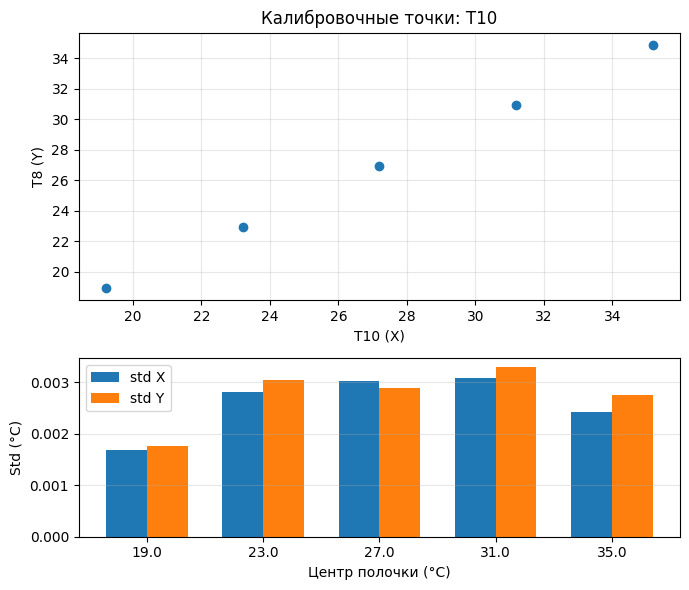

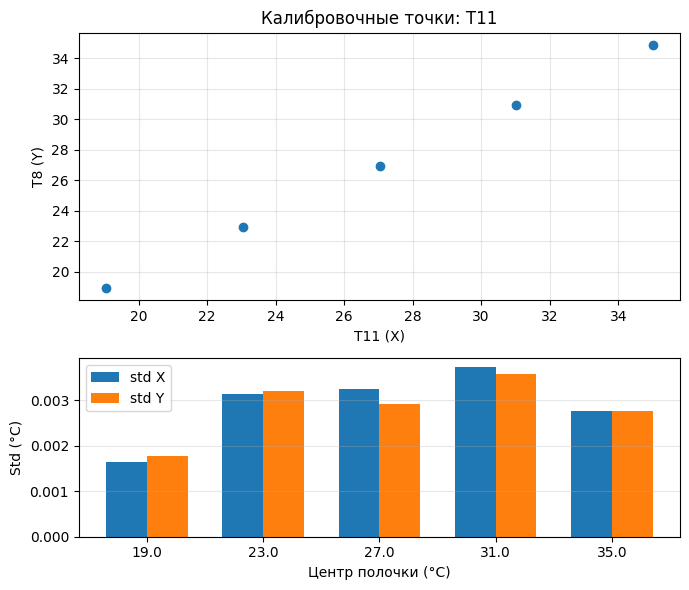

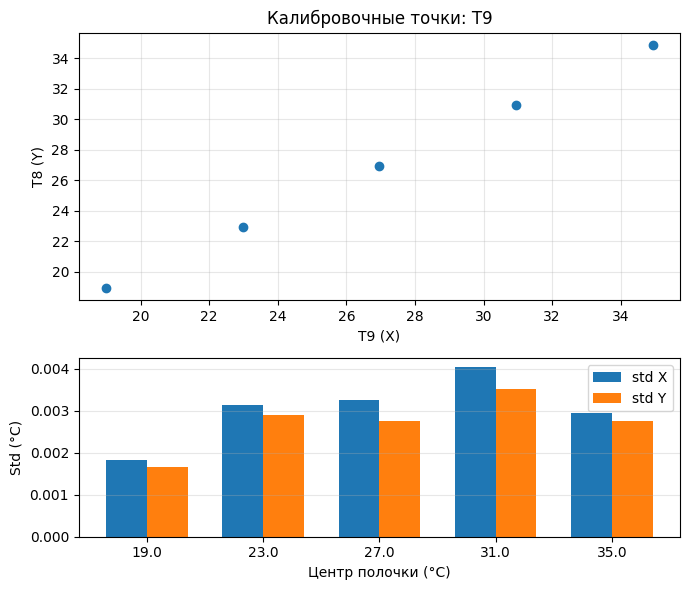

In [226]:
# === 10) Быстрый график калибровочных точек с ошибками ===
import matplotlib.pyplot as plt
import numpy as np
assert 'calibration_points_by_sensor' in globals() and not calibration_points_by_sensor.empty, 'Нет калибровочной таблицы.'
for sensor, g in calibration_points_by_sensor.groupby('sensor'):
    g = g.sort_values('bin_center')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6), gridspec_kw={'height_ratios':[3,2]})
    ax1.errorbar(g['x_mean'], g['y_mean'], xerr=g['x_std'], yerr=g['y_std'], fmt='o', capsize=3)
    ax1.set_xlabel(f'{sensor} (X)')
    ax1.set_ylabel(f'T{REF_IDX} (Y)')
    ax1.set_title(f'Калибровочные точки: {sensor}')
    ax1.grid(True, alpha=0.3)
    width=0.35; idx=np.arange(len(g))
    ax2.bar(idx - width/2, g['x_std'], width, label='std X')
    ax2.bar(idx + width/2, g['y_std'], width, label='std Y')
    ax2.set_xticks(idx)
    ax2.set_xticklabels([f'{bc:.1f}' for bc in g['bin_center']])
    ax2.set_xlabel('Центр полочки (°C)')
    ax2.set_ylabel('Std (°C)')
    ax2.legend(); ax2.grid(True, axis='y', alpha=0.3)
    plt.tight_layout(); plt.show()


Сенсор T10: 5 точек; степени 1..3
deg=1: Y = 0.99823743·X - 0.23297262
    coeffs (старшая→младшая): [0.99823743, -0.23297262] | RMSE=0.00579296, MAE=0.00544599, Max|err|=0.00842238
deg=2: Y = -0.0002045734·X^2 + 1.0091375·X - 0.37009624
    coeffs (старшая→младшая): [-0.0002045734, 1.0091375, -0.37009624] | RMSE=0.000284564, MAE=0.000226519, Max|err|=0.000417028
deg=3: Y = -6.9278956e-07·X^3 - 0.0001483649·X^2 + 1.0076576·X - 0.3574799
    coeffs (старшая→младшая): [-6.9278956e-07, -0.0001483649, 1.0076576, -0.3574799] | RMSE=0.000279245, MAE=0.000231007, Max|err|=0.000408741


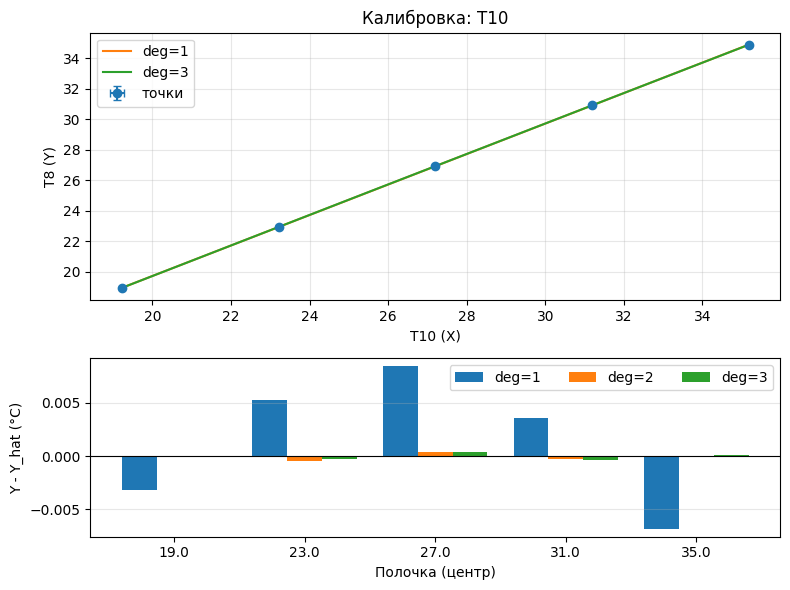

Сенсор T11: 5 точек; степени 1..3
deg=1: Y = 0.99852788·X - 0.072480866
    coeffs (старшая→младшая): [0.99852788, -0.072480866] | RMSE=0.00433166, MAE=0.00376679, Max|err|=0.0072364
deg=2: Y = -0.00015066835·X^2 + 1.0065111·X - 0.17215452
    coeffs (старшая→младшая): [-0.00015066835, 1.0065111, -0.17215452] | RMSE=0.00109856, MAE=0.000806918, Max|err|=0.00207535
deg=3: Y = 4.5438114e-06·X^3 - 0.00051707383·X^2 + 1.0160931·X - 0.25324492
    coeffs (старшая→младшая): [4.5438114e-06, -0.00051707383, 1.0160931, -0.25324492] | RMSE=0.000930372, MAE=0.000767593, Max|err|=0.00127322


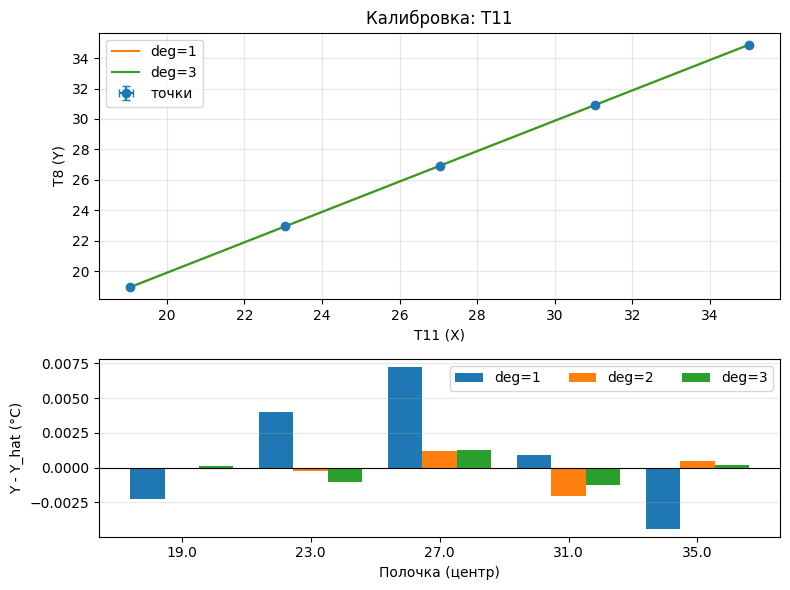

Сенсор T9: 5 точек; степени 1..3
deg=1: Y = 0.99939633·X - 0.028049315
    coeffs (старшая→младшая): [0.99939633, -0.028049315] | RMSE=0.00588956, MAE=0.00475408, Max|err|=0.0106458
deg=2: Y = -0.00019927774·X^2 + 1.0098977·X - 0.15856184
    coeffs (старшая→младшая): [-0.00019927774, 1.0098977, -0.15856184] | RMSE=0.00211821, MAE=0.00174615, Max|err|=0.00296203
deg=3: Y = -9.018501e-07·X^3 - 0.00012690576·X^2 + 1.0080145·X - 0.14269974
    coeffs (старшая→младшая): [-9.018501e-07, -0.00012690576, 1.0080145, -0.14269974] | RMSE=0.0021324, MAE=0.00175304, Max|err|=0.00312561


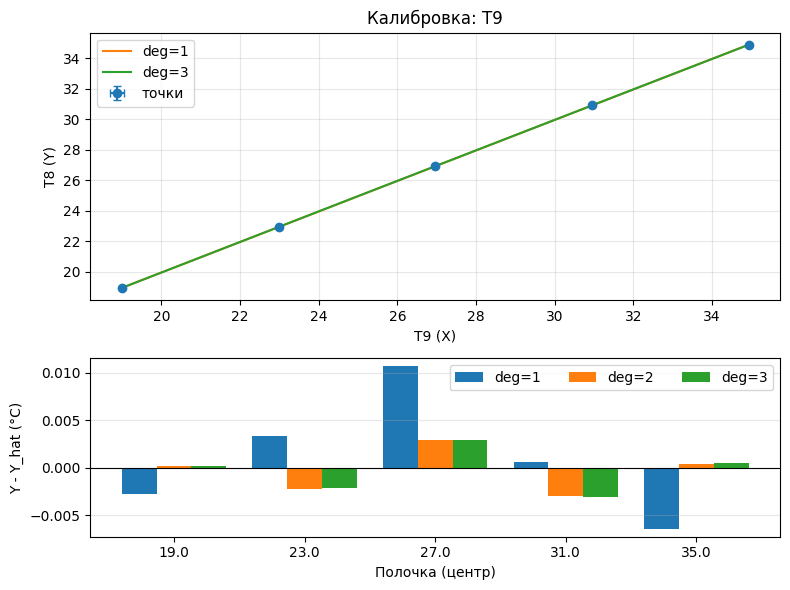

In [227]:
# === 11) Калибровочные кривые (полиномы) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert 'calibration_points_by_sensor' in globals() and not calibration_points_by_sensor.empty, 'Нет калибровочной таблицы.'

def _poly_formula(coeffs):
    # coeffs in descending order: c0*x^n + c1*x^(n-1) + ... + cN
    deg = len(coeffs) - 1
    terms = []
    for i, c in enumerate(coeffs):
        p = deg - i
        if abs(c) < 1e-15:
            continue
        coef = f"{c:.8g}"
        if p == 0:
            term = f"{coef}"
        elif p == 1:
            term = f"{coef}·X"
        else:
            term = f"{coef}·X^{p}"
        terms.append(term)
    if not terms:
        return 'Y = 0'
    s = ' + '.join(terms)
    s = s.replace('+ -','- ')
    return 'Y = ' + s

for sensor, g in calibration_points_by_sensor.groupby('sensor'):
    g = g.sort_values('x_mean').reset_index(drop=True)
    x = g['x_mean'].to_numpy(dtype=float)
    y = g['y_mean'].to_numpy(dtype=float)
    y_std = g['y_std'].to_numpy(dtype=float) if 'y_std' in g else np.full_like(y, np.nan)
    w = 1.0 / np.clip(y_std, 1e-9, np.inf)
    n = len(x)
    deg_max = max(1, n - 2)

    fits = []
    for d in range(1, deg_max + 1):
        try:
            coefs = np.polyfit(x, y, deg=d, w=w)
            p = np.poly1d(coefs)
            yhat = p(x)
            resid = y - yhat
            rmse = float(np.sqrt(np.mean(resid**2)))
            mae = float(np.mean(np.abs(resid)))
            mx = float(np.max(np.abs(resid)))
            fits.append({'deg': d, 'coefs': coefs, 'poly': p, 'rmse': rmse, 'mae': mae, 'maxerr': mx, 'resid': resid})
        except Exception as e:
            print(f"[warn] {sensor}: не удалось аппроксимировать степенью {d}: {e}")

    print(f"Сенсор {sensor}: {n} точек; степени 1..{deg_max}")
    for f in fits:
        cdesc = ', '.join([f"{c:.8g}" for c in f['coefs']])
        print(f"deg={f['deg']}: {_poly_formula(f['coefs'])}")
        print(f"    coeffs (старшая→младшая): [{cdesc}] | RMSE={f['rmse']:.6g}, MAE={f['mae']:.6g}, Max|err|={f['maxerr']:.6g}")

    # Визуализация: X–Y с кривыми и остатки по степеням
    xs = np.linspace(float(x.min()), float(x.max()), 200)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 2]})

    # Верх: точки с ошибками и две кривые (deg=1 и deg_max)
    ax1.errorbar(x, y, xerr=g.get('x_std', pd.Series(index=g.index, dtype=float)), yerr=g.get('y_std', pd.Series(index=g.index, dtype=float)), fmt='o', capsize=3, label='точки')
    p1 = next((f['poly'] for f in fits if f['deg'] == 1), None)
    pN = max(fits, key=lambda f: f['deg'])['poly'] if fits else None
    if p1 is not None:
        ax1.plot(xs, p1(xs), label='deg=1')
    if pN is not None and (p1 is None or pN.order != 1):
        ax1.plot(xs, pN(xs), label=f"deg={pN.order}")
    ax1.set_xlabel(f"{sensor} (X)")
    ax1.set_ylabel(f"T{REF_IDX} (Y)")
    ax1.set_title(f"Калибровка: {sensor}")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Низ: остатки Y - Y_hat для каждой степени (кластерные столбцы)
    idx = np.arange(n)
    width = 0.8 / max(len(fits), 1)
    for k, f in enumerate(fits):
        ax2.bar(idx + (k - (len(fits)-1)/2)*width, f['resid'], width, label=f"deg={f['deg']}")
    ax2.axhline(0, color='k', lw=0.8)
    if 'bin_center' in g.columns:
        labels = [f"{bc:.1f}" for bc in g['bin_center']]
    else:
        labels = [f"{xi:.2f}" for xi in x]
    ax2.set_xticks(idx)
    ax2.set_xticklabels(labels)
    ax2.set_xlabel('Полочка (центр)')
    ax2.set_ylabel('Y - Y_hat (°C)')
    ax2.legend(ncol=min(4, len(fits)))
    ax2.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


Сенсор T10: 5 точек; степени 1..3
L2 deg=1: Y = 0.99823743·X - 0.23297262
    coeffs (старшая→младшая): [0.99823743, -0.23297262] | RMSE=0.00579296, MAE=0.00544599, Max|err|=0.00842238
L_inf deg=1: Y = 0.99817029·X - 0.23024137
    coeffs (старшая→младшая): [0.99817029, -0.23024137] | RMSE=0.00556026, MAE=0.00526514, Max|err|=0.00751746
L2 deg=2: Y = -0.0002045734·X^2 + 1.0091375·X - 0.37009624
    coeffs (старшая→младшая): [-0.0002045734, 1.0091375, -0.37009624] | RMSE=0.000284564, MAE=0.000226519, Max|err|=0.000417028
L_inf deg=2: Y = -0.00020498202·X^2 + 1.009186·X - 0.37104956
    coeffs (старшая→младшая): [-0.00020498202, 1.009186, -0.37104956] | RMSE=0.000322594, MAE=0.000313477, Max|err|=0.000401512
L2 deg=3: Y = -6.9278956e-07·X^3 - 0.0001483649·X^2 + 1.0076576·X - 0.3574799
    coeffs (старшая→младшая): [-6.9278956e-07, -0.0001483649, 1.0076576, -0.3574799] | RMSE=0.000279245, MAE=0.000231007, Max|err|=0.000408741
L_inf deg=3: Y = -7.2078491e-07·X^3 - 0.00015073517·X^2 + 1.007

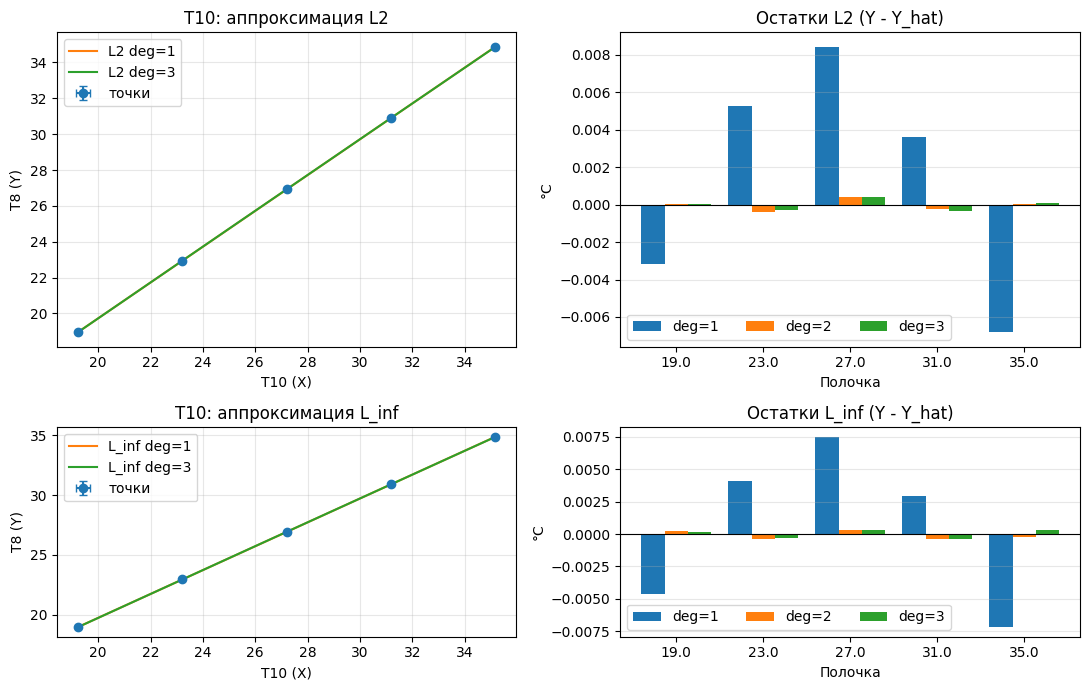

Сенсор T11: 5 точек; степени 1..3
L2 deg=1: Y = 0.99852788·X - 0.072480866
    coeffs (старшая→младшая): [0.99852788, -0.072480866] | RMSE=0.00433166, MAE=0.00376679, Max|err|=0.0072364
L_inf deg=1: Y = 0.99852325·X - 0.071072437
    coeffs (старшая→младшая): [0.99852325, -0.071072437] | RMSE=0.00419038, MAE=0.00365541, Max|err|=0.00595301
L2 deg=2: Y = -0.00015066835·X^2 + 1.0065111·X - 0.17215452
    coeffs (старшая→младшая): [-0.00015066835, 1.0065111, -0.17215452] | RMSE=0.00109856, MAE=0.000806918, Max|err|=0.00207535
L_inf deg=2: Y = -0.00014937608·X^2 + 1.0063434·X - 0.16866584
    coeffs (старшая→младшая): [-0.00014937608, 1.0063434, -0.16866584] | RMSE=0.00116573, MAE=0.00110697, Max|err|=0.00160377
L2 deg=3: Y = 4.5438114e-06·X^3 - 0.00051707383·X^2 + 1.0160931·X - 0.25324492
    coeffs (старшая→младшая): [4.5438114e-06, -0.00051707383, 1.0160931, -0.25324492] | RMSE=0.000930372, MAE=0.000767593, Max|err|=0.00127322
L_inf deg=3: Y = 4.5470221e-06·X^3 - 0.00053159938·X^2 + 1.0

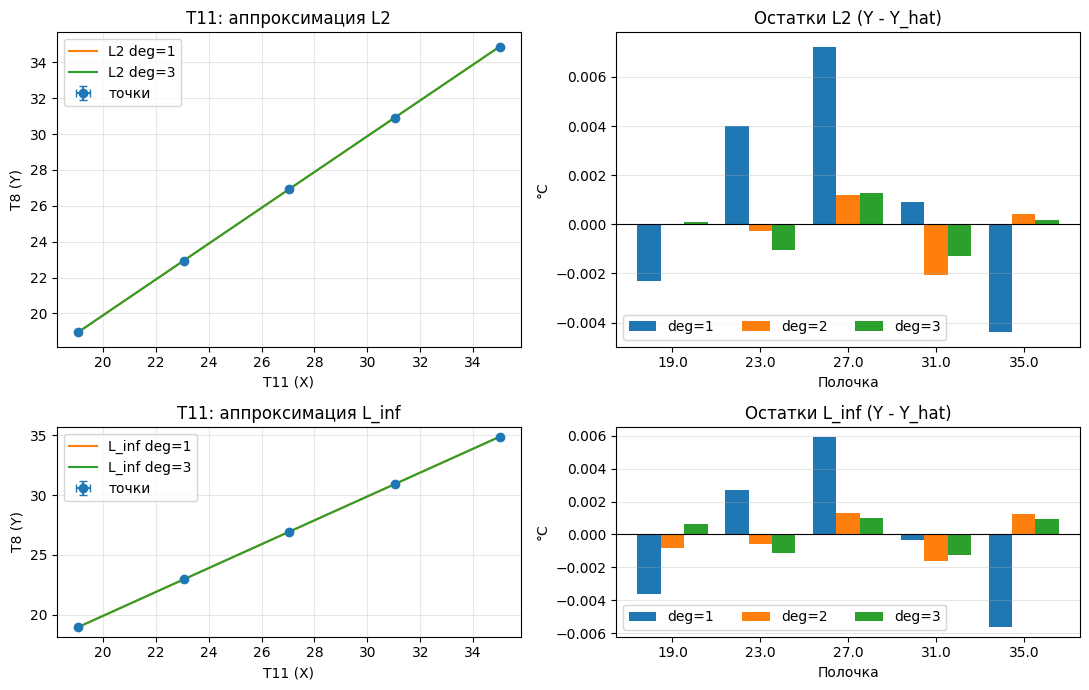

Сенсор T9: 5 точек; степени 1..3
L2 deg=1: Y = 0.99939633·X - 0.028049315
    coeffs (старшая→младшая): [0.99939633, -0.028049315] | RMSE=0.00588956, MAE=0.00475408, Max|err|=0.0106458
L_inf deg=1: Y = 0.99938102·X - 0.025443722
    coeffs (старшая→младшая): [0.99938102, -0.025443722] | RMSE=0.00587233, MAE=0.00491071, Max|err|=0.00848262
L2 deg=2: Y = -0.00019927774·X^2 + 1.0098977·X - 0.15856184
    coeffs (старшая→младшая): [-0.00019927774, 1.0098977, -0.15856184] | RMSE=0.00211821, MAE=0.00174615, Max|err|=0.00296203
L_inf deg=2: Y = -0.00022980545·X^2 + 1.0115221·X - 0.17959555
    coeffs (старшая→младшая): [-0.00022980545, 1.0115221, -0.17959555] | RMSE=0.00227379, MAE=0.00221316, Max|err|=0.00295941
L2 deg=3: Y = -9.018501e-07·X^3 - 0.00012690576·X^2 + 1.0080145·X - 0.14269974
    coeffs (старшая→младшая): [-9.018501e-07, -0.00012690576, 1.0080145, -0.14269974] | RMSE=0.0021324, MAE=0.00175304, Max|err|=0.00312561
L_inf deg=3: Y = -4.409281e-07·X^3 - 0.00019697451·X^2 + 1.010719

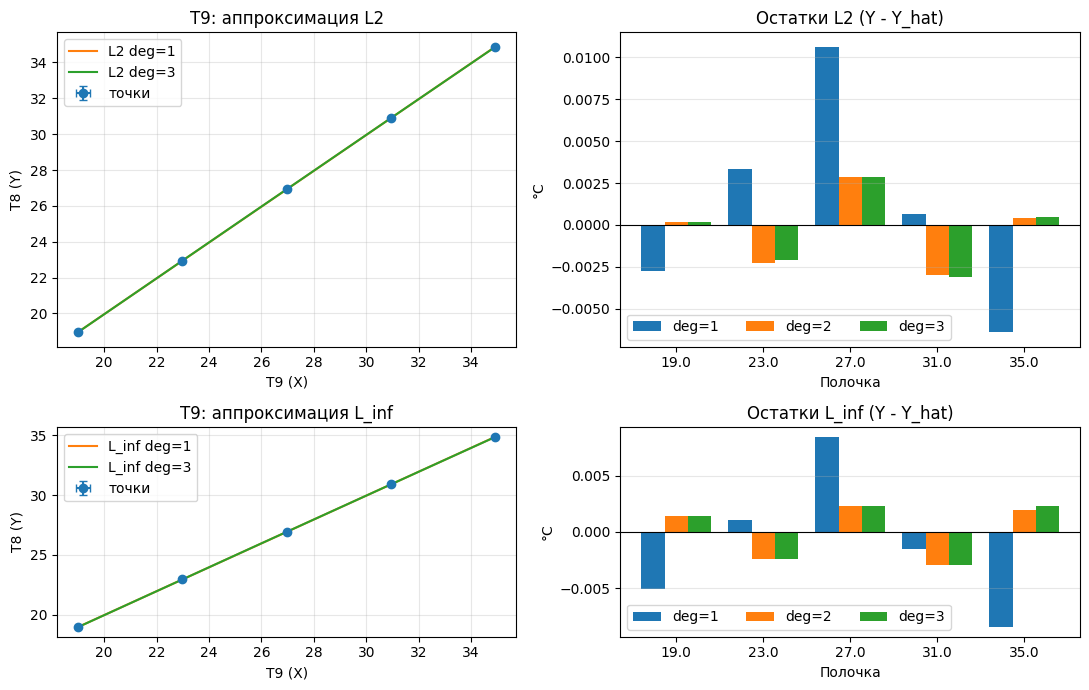

Сохранено: calibration_models.csv (18 строк)


In [228]:
# === 12) Калибровочные модели (L2 и L_inf) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert 'calibration_points_by_sensor' in globals() and not calibration_points_by_sensor.empty, 'Нет калибровочной таблицы.'

try:
    from scipy.optimize import linprog  # optional, для точной L_inf
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

def _build_vandermonde(x, deg):
    # Descending powers
    return np.vander(x, N=deg+1, increasing=False)

def _poly_formula(coeffs):
    deg = len(coeffs) - 1
    parts = []
    for i, c in enumerate(coeffs):
        p = deg - i
        if abs(c) < 1e-15:
            continue
        coef = f"{c:.8g}"
        if p == 0:
            parts.append(f"{coef}")
        elif p == 1:
            parts.append(f"{coef}·X")
        else:
            parts.append(f"{coef}·X^{p}")
    if not parts:
        return 'Y = 0'
    expr = ' + '.join(parts).replace('+ -', '- ')
    return 'Y = ' + expr

def fit_L2(x, y, deg, y_std=None):
    if y_std is not None:
        w = 1.0 / np.clip(y_std, 1e-12, np.inf)
        coefs = np.polyfit(x, y, deg=deg, w=w)
    else:
        coefs = np.polyfit(x, y, deg=deg)
    p = np.poly1d(coefs)
    yhat = p(x)
    resid = y - yhat
    return coefs, p, resid

def fit_Linf(x, y, deg, y_std=None, max_iter_irls=25):
    # Минимакс через LP, если доступен SciPy. Иначе — IRLS-приближение к L_inf.
    if _HAS_SCIPY:
        X = _build_vandermonde(x, deg)
        if y_std is not None:
            w = 1.0 / np.clip(y_std, 1e-12, np.inf)
            Xw = X * w[:, None]
            yw = y * w
        else:
            Xw = X
            yw = y
        n, m = Xw.shape
        # Variables: c (m coeffs) and t (scalar)
        # Minimize t subject to:  X c - t <= y;  -X c - t <= -y
        # Build A_ub, b_ub for z=[c;t]
        A1 = np.hstack([Xw, -np.ones((n,1))])
        b1 = yw
        A2 = np.hstack([-Xw, -np.ones((n,1))])
        b2 = -yw
        A_ub = np.vstack([A1, A2])
        b_ub = np.concatenate([b1, b2])
        c_vec = np.zeros(m+1); c_vec[-1] = 1.0
        bounds = [(None, None)]*m + [(0, None)]
        res = linprog(c_vec, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
        if not res.success:
            raise RuntimeError('linprog failed: ' + str(res.message))
        coefs = res.x[:-1]
        p = np.poly1d(coefs)
        yhat = p(x)
        resid = y - yhat
        return coefs, p, resid
    # Fallback IRLS to approximate L_inf: повышаем веса у больших остатков
    # Старт — L2
    coefs = np.polyfit(x, y, deg=deg)
    for _ in range(max_iter_irls):
        p = np.poly1d(coefs)
        resid = y - p(x)
        s = np.clip(np.abs(resid), 1e-9, None)
        # scale by std if provided
        if y_std is not None:
            s = s / np.clip(y_std, 1e-12, np.inf)
        w = 1.0 / s
        coefs = np.polyfit(x, y, deg=deg, w=w)
    p = np.poly1d(coefs)
    resid = y - p(x)
    return coefs, p, resid

rows = []

for sensor, g in calibration_points_by_sensor.groupby('sensor'):
    g = g.sort_values('x_mean').reset_index(drop=True)
    x = g['x_mean'].to_numpy(float)
    y = g['y_mean'].to_numpy(float)
    y_std = g['y_std'].to_numpy(float) if 'y_std' in g else None
    n = len(x)
    deg_max = max(1, n - 2)

    model_bank = []
    # L2 and L_inf for each degree
    for d in range(1, deg_max+1):
        # L2
        c2, p2, r2 = fit_L2(x, y, d, y_std)
        rmse2 = float(np.sqrt(np.mean(r2**2)))
        mae2 = float(np.mean(np.abs(r2)))
        mx2 = float(np.max(np.abs(r2)))
        model_bank.append({'sensor':sensor,'method':'L2','deg':d,'coefs':c2,'poly':p2,'resid':r2,'rmse':rmse2,'mae':mae2,'maxerr':mx2})
        # L_inf
        cI, pI, rI = fit_Linf(x, y, d, y_std)
        rmseI = float(np.sqrt(np.mean(rI**2)))
        maeI = float(np.mean(np.abs(rI)))
        mxI = float(np.max(np.abs(rI)))
        model_bank.append({'sensor':sensor,'method':'L_inf','deg':d,'coefs':cI,'poly':pI,'resid':rI,'rmse':rmseI,'mae':maeI,'maxerr':mxI})

    # Печать формул и метрик
    print(f"Сенсор {sensor}: {n} точек; степени 1..{deg_max}")
    for f in model_bank:
        cdesc = ', '.join([f"{c:.8g}" for c in f['coefs']])
        print(f"{f['method']} deg={f['deg']}: {_poly_formula(f['coefs'])}")
        print(f"    coeffs (старшая→младшая): [{cdesc}] | RMSE={f['rmse']:.6g}, MAE={f['mae']:.6g}, Max|err|={f['maxerr']:.6g}")

    # Таблица коэффициентов
    for f in model_bank:
        row = {
            'sensor': f['sensor'],
            'method': f['method'],
            'degree': f['deg'],
            'n_points': n,
            'rmse': f['rmse'],
            'mae': f['mae'],
            'maxerr': f['maxerr'],
            'formula': _poly_formula(f['coefs'])
        }
        # Разложим по степеням: c_p{p}
        d = f['deg']
        for i, c in enumerate(f['coefs']):
            pwr = d - i
            row[f'c_p{pwr}'] = float(c)
        rows.append(row)

    # Графики: отдельно для L2 и L_inf (deg=1 и deg=deg_max)
    xs = np.linspace(float(x.min()), float(x.max()), 200)
    fig, axes = plt.subplots(2, 2, figsize=(11, 7), gridspec_kw={'height_ratios':[3,2]})
    (ax1, ax2), (ax3, ax4) = axes

    # L2 — точки и кривые
    ax1.errorbar(x, y,
                 xerr=g.get('x_std', pd.Series(index=g.index, dtype=float)),
                 yerr=g.get('y_std', pd.Series(index=g.index, dtype=float)),
                 fmt='o', capsize=3, label='точки')
    p2_1 = next((f['poly'] for f in model_bank if f['method']=='L2' and f['deg']==1), None)
    p2_N = next((f['poly'] for f in model_bank if f['method']=='L2' and f['deg']==deg_max), None)
    if p2_1 is not None: ax1.plot(xs, p2_1(xs), label='L2 deg=1')
    if p2_N is not None and (p2_1 is None or p2_N.order != 1): ax1.plot(xs, p2_N(xs), label=f'L2 deg={p2_N.order}')
    ax1.set_title(f'{sensor}: аппроксимация L2')
    ax1.set_xlabel(f'{sensor} (X)'); ax1.set_ylabel(f'T{REF_IDX} (Y)'); ax1.grid(True, alpha=0.3); ax1.legend()

    # L2 — остатки
    idx = np.arange(n); width = 0.8 / max(deg_max,1)
    for d in range(1, deg_max+1):
        r = next(f['resid'] for f in model_bank if f['method']=='L2' and f['deg']==d)
        ax2.bar(idx + (d-1 - (deg_max-1)/2)*width, r, width, label=f'deg={d}')
    ax2.axhline(0, color='k', lw=0.8)
    labels = [f"{bc:.1f}" for bc in g['bin_center']] if 'bin_center' in g else [f"{xi:.2f}" for xi in x]
    ax2.set_xticks(idx); ax2.set_xticklabels(labels)
    ax2.set_title('Остатки L2 (Y - Y_hat)'); ax2.set_xlabel('Полочка'); ax2.set_ylabel('°C'); ax2.grid(True, axis='y', alpha=0.3); ax2.legend(ncol=min(4, deg_max))

    # L_inf — точки и кривые
    ax3.errorbar(x, y,
                 xerr=g.get('x_std', pd.Series(index=g.index, dtype=float)),
                 yerr=g.get('y_std', pd.Series(index=g.index, dtype=float)),
                 fmt='o', capsize=3, label='точки')
    pI_1 = next((f['poly'] for f in model_bank if f['method']=='L_inf' and f['deg']==1), None)
    pI_N = next((f['poly'] for f in model_bank if f['method']=='L_inf' and f['deg']==deg_max), None)
    if pI_1 is not None: ax3.plot(xs, pI_1(xs), label='L_inf deg=1')
    if pI_N is not None and (pI_1 is None or pI_N.order != 1): ax3.plot(xs, pI_N(xs), label=f'L_inf deg={pI_N.order}')
    ax3.set_title(f'{sensor}: аппроксимация L_inf' + ('' if _HAS_SCIPY else ' (IRLS-приближение)'))
    ax3.set_xlabel(f'{sensor} (X)'); ax3.set_ylabel(f'T{REF_IDX} (Y)'); ax3.grid(True, alpha=0.3); ax3.legend()

    # L_inf — остатки
    idx = np.arange(n); width = 0.8 / max(deg_max,1)
    for d in range(1, deg_max+1):
        r = next(f['resid'] for f in model_bank if f['method']=='L_inf' and f['deg']==d)
        ax4.bar(idx + (d-1 - (deg_max-1)/2)*width, r, width, label=f'deg={d}')
    ax4.axhline(0, color='k', lw=0.8)
    ax4.set_xticks(idx); ax4.set_xticklabels(labels)
    ax4.set_title('Остатки L_inf (Y - Y_hat)'); ax4.set_xlabel('Полочка'); ax4.set_ylabel('°C'); ax4.grid(True, axis='y', alpha=0.3); ax4.legend(ncol=min(4, deg_max))

    plt.tight_layout(); plt.show()

# Соберём общую таблицу моделей и сохраним
calibration_models = pd.DataFrame(rows)
out_csv = 'calibration_models.csv'
calibration_models.to_csv(out_csv, index=False)
print(f"Сохранено: {out_csv} ({len(calibration_models)} строк)")


In [231]:
# === 13) HTML-отчёт калибровки ===
import os, io, base64, datetime as _dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

assert 'calibration_points_by_sensor' in globals() and not calibration_points_by_sensor.empty, 'Нет калибровочной таблицы.'

REF_COL = f'T{REF_IDX}'
REF_DISPLAY = globals().get('REF_NAME', REF_COL)

# Нормализуем имена из SENSOR_NAMES (dict by 'T*' | dict by 1..N | list/tuple)
_raw_names = globals().get('SENSOR_NAMES', {})
_name_map = {}
_ordered_cols = [f'T{REF_IDX+i}' for i in range(1, N_FOLLOW+1)]
if isinstance(_raw_names, (list, tuple)):
    for i, nm in enumerate(_raw_names, start=1):
        if i <= len(_ordered_cols):
            _name_map[_ordered_cols[i-1]] = str(nm)
elif isinstance(_raw_names, dict):
    for k, v in _raw_names.items():
        try:
            if isinstance(k, str) and k.startswith('T'):
                _name_map[k] = str(v)
            else:
                idx = int(k)
                if 1 <= idx <= len(_ordered_cols):
                    _name_map[_ordered_cols[idx-1]] = str(v)
        except Exception:
            pass
NAME_MAP = _name_map

def _fig_to_b64(fig):
    bio = io.BytesIO(); fig.savefig(bio, format='png', dpi=140, bbox_inches='tight'); plt.close(fig)
    return base64.b64encode(bio.getvalue()).decode('ascii')

def _html_escape(s):
    return (str(s).replace('&','&amp;').replace('<','&lt;').replace('>','&gt;'))

def _sensor_order(sensors):
    def key(c):
        try: return int(str(c).lstrip('T'))
        except: return 10**9
    return sorted(list(sensors), key=key)

present = list(calibration_points_by_sensor['sensor'].unique())
FOLLOW_ORDER = _sensor_order(present)

now = _dt.datetime.now().strftime('%Y-%m-%d %H:%M')
parts = []
parts.append(f'<h1>Краткий отчёт калибровки</h1>')
parts.append(f'<p>Время формирования: {now}</p>')
parts.append('<h2>Сенсоры</h2>')
parts.append('<ul>')
parts.append(f'<li>Эталон: {_html_escape(REF_DISPLAY)} ({_html_escape(REF_COL)})</li>')
for i, s in enumerate(FOLLOW_ORDER, start=1):
    friendly = NAME_MAP.get(s, s)
    parts.append(f"<li>Калибруемый: Датчик {i}: {_html_escape(friendly)} ({_html_escape(s)})</li>")
parts.append('</ul>')

# Комментарий о соответствии «Датчик 1..3»
_mapping_items = []
for i, col in enumerate(FOLLOW_ORDER, start=1):
    _mapping_items.append(f"Датчик {i} = {_html_escape(NAME_MAP.get(col, col))} ({_html_escape(col)})")
parts.append('<p><i>Нумерация:</i> ' + '; '.join(_mapping_items) + '</p>')

# Формулы и метрики (степень N−2)
if 'calibration_models' in globals() and calibration_models is not None and not calibration_models.empty:
    parts.append('<h2>Формулы калибровки (степень N−2) и метрики</h2>')
    for s in FOLLOW_ORDER:
        disp = NAME_MAP.get(s, s)
        cm = calibration_models[calibration_models['sensor']==s]
        if cm.empty: continue
        n_pts = int(cm['n_points'].max()) if 'n_points' in cm.columns else len(calibration_points_by_sensor[calibration_points_by_sensor['sensor']==s])
        deg_star = max(1, n_pts - 2)
        best_L2_star = cm[(cm['method']=='L2') & (cm['degree']==deg_star)].head(1)
        best_LI_star = cm[(cm['method']=='L_inf') & (cm['degree']==deg_star)].head(1)
        parts.append(f'<h3>{_html_escape(disp)}</h3>')
        if not best_L2_star.empty:
            r = best_L2_star.iloc[0]
            parts.append(f"<p><b>L2:</b> {_html_escape(r['formula'])} | RMSE={r['rmse']:.6g}, MAE={r['mae']:.6g}, Max|err|={r['maxerr']:.6g}</p>")
        if not best_LI_star.empty:
            r = best_LI_star.iloc[0]
            parts.append(f"<p><b>L_inf:</b> {_html_escape(r['formula'])} | RMSE={r['rmse']:.6g}, MAE={r['mae']:.6g}, Max|err|={r['maxerr']:.6g}</p>")
else:
    parts.append('<h2>Формулы калибровки</h2><p>Сначала выполните ячейку 12 (модели).</p>')

# Калибровочные таблицы X–Y
parts.append('<h2>Калибровочные точки X–Y</h2>')
for s in FOLLOW_ORDER:
    g = calibration_points_by_sensor[calibration_points_by_sensor['sensor']==s].copy()
    disp = NAME_MAP.get(s, s)
    cols = ['bin_center','x_mean','y_mean','x_std','y_std','n_samples','start_date','end_date']
    for c in cols:
        if c not in g.columns: g[c] = np.nan
    parts.append(f'<h3>{_html_escape(disp)}</h3>')
    parts.append(g[cols].to_html(index=False, float_format=lambda v: f"{v:.6g}"))

# Графики стабильных интервалов и их размеров
if 'STABLE_BY_SENSOR' in globals() and STABLE_BY_SENSOR is not None and not STABLE_BY_SENSOR.empty:
    parts.append('<h2>Стабильные интервалы (выбранные) и их размеры</h2>')
    for s in FOLLOW_ORDER:
        disp = NAME_MAP.get(s, s)
        t = STABLE_BY_SENSOR[STABLE_BY_SENSOR['sensor']==s]
        if t.empty: continue
        td = t.copy(); td['start_date'] = pd.to_datetime(td['start_date']); td['end_date'] = pd.to_datetime(td['end_date'])
        tdd = td.reset_index(drop=True)
        fig, ax = plt.subplots(figsize=(8, max(2, 0.3*len(tdd))))
        y = np.arange(len(tdd))
        for i, row in tdd.iterrows():
            sdt = row['start_date']; edt = row['end_date']
            ax.hlines(i, sdt, edt, colors='C0', linewidth=6)
            ax.text(edt, i, f"  n={int(row['length'])}", va='center', fontsize=8)
        ax.set_yticks(y); ax.set_yticklabels([f"seg {i+1}" for i in y])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        ax.set_title(f'{_html_escape(disp)}: стабильные отрезки (выбранные)')
        ax.set_xlabel('Время'); ax.set_ylabel('Сегменты'); ax.grid(True, axis='x', alpha=0.3)
        fig.autofmt_xdate()
        parts.append(f'<p><img src="data:image/png;base64,{_fig_to_b64(fig)}" alt="{_html_escape(disp)} intervals"/></p>')

# Детали аппроксимации — детерминированно
parts.append('<h2>Детали аппроксимации</h2>')
_use_scipy = False
try:
    import scipy
    _use_scipy = True
except Exception:
    _use_scipy = False
parts.append('<ul>')
parts.append('<li>L2 — взвешенная МНК (веса 1/max(y_std, ε) при наличии std эталона).</li>')
parts.append('<li>' + ('L_inf — минимакс через линейное программирование (SciPy HiGHS).' if _use_scipy else 'L_inf — минимакс, реализованный устойчивым IRLS‑методом.') + '</li>')
parts.append('<li>Степени перебираются от 1 до N−2 (где N — число калибровочных точек).</li>')
parts.append('<li>Калибровочные точки формируются из самых длинных стабильных интервалов в центрированных корзинах 1°C.</li>')
parts.append('</ul>')

# Приложение: ключевые графики из ноутбука (на каждый датчик)
parts.append('<h2>Приложение: графики из ноутбука</h2>')
for s in FOLLOW_ORDER:
    disp = NAME_MAP.get(s, s)
    g = calibration_points_by_sensor[calibration_points_by_sensor['sensor']==s].sort_values('bin_center')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6), gridspec_kw={'height_ratios':[3,2]})
    ax1.errorbar(g['x_mean'], g['y_mean'], xerr=g.get('x_std'), yerr=g.get('y_std'), fmt='o', capsize=3)
    ax1.set_xlabel(f'{s} (X)'); ax1.set_ylabel(f'{REF_COL} (Y)'); ax1.set_title(f'{_html_escape(disp)}: X–Y с ошибками'); ax1.grid(True, alpha=0.3)
    idx = np.arange(len(g)); width = 0.35
    ax2.bar(idx - width/2, g['x_std'], width, label='std X')
    ax2.bar(idx + width/2, g['y_std'], width, label='std Y')
    ax2.set_xticks(idx); ax2.set_xticklabels([f"{bc:.1f}" for bc in g['bin_center']])
    ax2.set_xlabel('Центр полочки (°C)'); ax2.set_ylabel('Std (°C)'); ax2.legend(); ax2.grid(True, axis='y', alpha=0.3)
    parts.append(f'<p><b>{_html_escape(disp)} — обзор X–Y и ошибки.</b></p>')
    parts.append(f'<p><img src="data:image/png;base64,{_fig_to_b64(fig)}" alt="{_html_escape(disp)} xy"/></p>')

html = (
    '<html><head><meta charset="utf-8"><title>Отчёт калибровки</title>'
    '<style>body{font-family:Segoe UI,Arial,sans-serif;line-height:1.35} '
    'table{border-collapse:collapse} td,th{border:1px solid #ddd;padding:4px 6px} '
    'h1,h2{margin-top:1em}</style>'
    '</head><body>' + '\n'.join(parts) + '</body></html>'
)

out_path = os.path.join(os.getcwd(), 'calibration_report.html')
with open(out_path, 'w', encoding='utf-8') as f:
    f.write(html)
print('HTML-отчёт сохранён:', out_path)


HTML-отчёт сохранён: c:\Users\Alexander\source\repos\sensor_calibration\calibration_report.html
